# Proto2 Winter Analysis

### import necessary modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

#### import functions I've written and that are locally stored

In [2]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients

### import proto 2 data 

In [3]:
proto2_despiked = pd.read_csv('/data/aq/nyserda/proto2/extended_analysis_data/despiked_proto2_ext.csv')
proto2_despiked = proto2_despiked.drop('Unnamed: 0',1)

In [4]:
proto2_despiked['datetime'] = pd.to_datetime(proto2_despiked['datefield'],format='%Y-%m-%d %H:%M:%S')
proto2_despiked = proto2_despiked.set_index('datetime')
houravg = proto2_despiked.resample('60min').mean()

### import dec reference data 

In [5]:
path_epa='/data/aq/DEC/DEC_may2021-dec2022_csv/'
epa_filepaths = []
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

#epa_from_files = (pd.read_csv(f,encoding='cp1252') for f in epa_filepaths) # https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
epa_from_files = (pd.read_csv(f,encoding='cp437') for f in epa_filepaths) # https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character

epa_df = pd.concat(epa_from_files) 

In [6]:
epa_df;

In [7]:
epa_df = epa_df.drop(columns=['Unnamed: 0'])

##### .. correct CO and ozone concentrations and calculate NO

In [8]:
epa_df['Carbon monoxide']=epa_df['Carbon monoxide']*1000
epa_df['Ozone']=epa_df['Ozone']*1000
epa_df['Nitrogen oxide']=epa_df['Oxides of nitrogen (NOx)']-epa_df['Nitrogen dioxide (NO2)']

In [9]:
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
#epa_table={42101:'Carbon monoxide',44201:'Ozone',42601:'Oxides of nitrogen (NOx)',42602:'Nitrogen dioxide (NO2)',88101:'PM2.5 - Local Conditions'}
epa_df.rename(columns={'PM2.5 - Local Conditions': 'PM2.5', 'Nitrogen dioxide (NO2)': 'NO2','Carbon monoxide':'CO', 
                       'Oxides of nitrogen (NOx)':'NOx','Ozone':'O3','Nitrogen oxide':'NO'},inplace=True)

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [10]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [11]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [12]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;
#set dictionary that matches varid to field name
#proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
#epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

#### .. choose only October data 

In [13]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_oct = epa_df_matching_proto2.loc['2021-10-01 00:00:00+00:00':'2021-10-31 23:00:00+00:00']
proto2_oct = houravg.loc[DEC_oct.index]

#### .. assessing data completeness 

#### .. plot DEC data to visualize completeness 

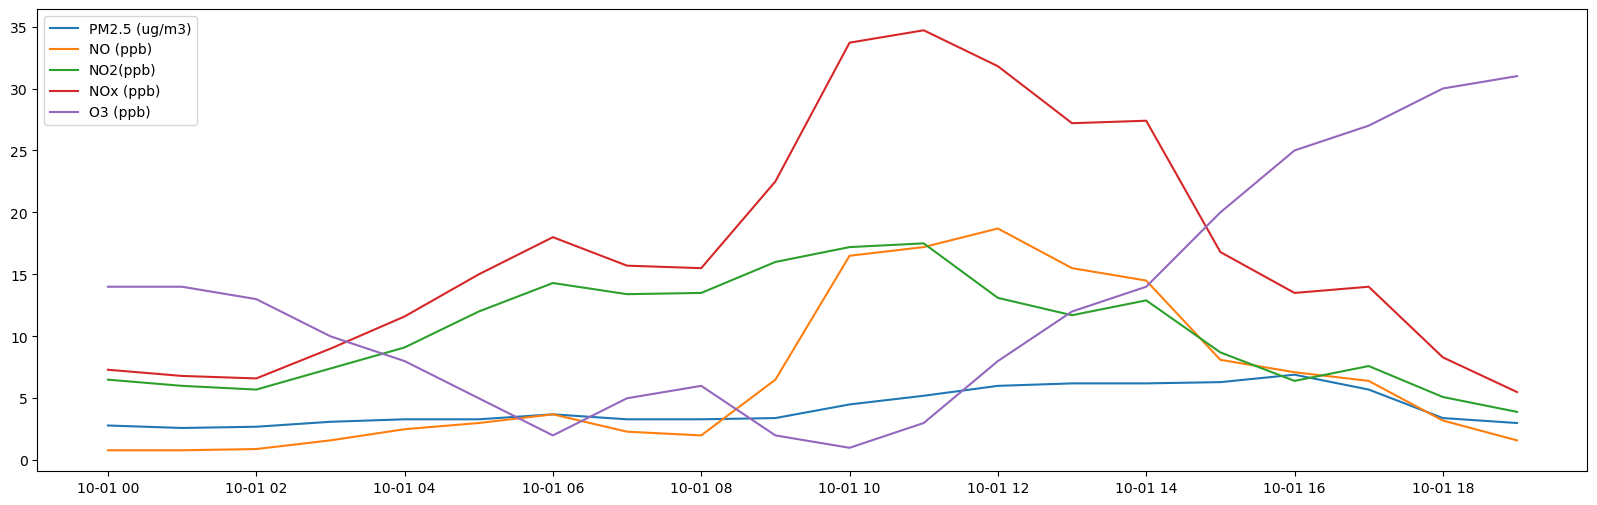

In [14]:
plt.figure(figsize=(20,6))
plt.plot(DEC_oct['PM2.5'].head(20), label='PM2.5 (ug/m3)')
plt.plot(DEC_oct['NO'].head(20), label='NO (ppb)')
plt.plot(DEC_oct['NO2'].head(20), label='NO2(ppb)')
plt.plot(DEC_oct['NOx'].head(20), label='NOx (ppb)')
plt.plot(DEC_oct['O3'].head(20), label='O3 (ppb)')
#plt.plot(DEC_sept['TEMP (Deg F)'], label='Temp (degF)')
plt.legend()

## .. calculate what percentage of data for each pollutant contains a NaN value...

In [15]:
data = DEC_oct.columns
data = data.drop(['date'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_oct[col].isna().sum()/len(DEC_oct))*100).round(2),'%')

PM2.5  percent NaN =  0.13 %
NO2  percent NaN =  4.03 %
CO  percent NaN =  2.02 %
NOx  percent NaN =  4.03 %
O3  percent NaN =  1.34 %
NO  percent NaN =  4.03 %


#### .. remove NaN from DEC and reindex to match proto2

In [16]:
DEC_oct = DEC_oct.dropna(axis=0)
proto2_oct_match2DEC = proto2_oct.loc[proto2_oct.index.isin(DEC_oct.index)]
proto2_oct_match2DEC;

#### .. check PM25 data to ensure timezone correction is working 

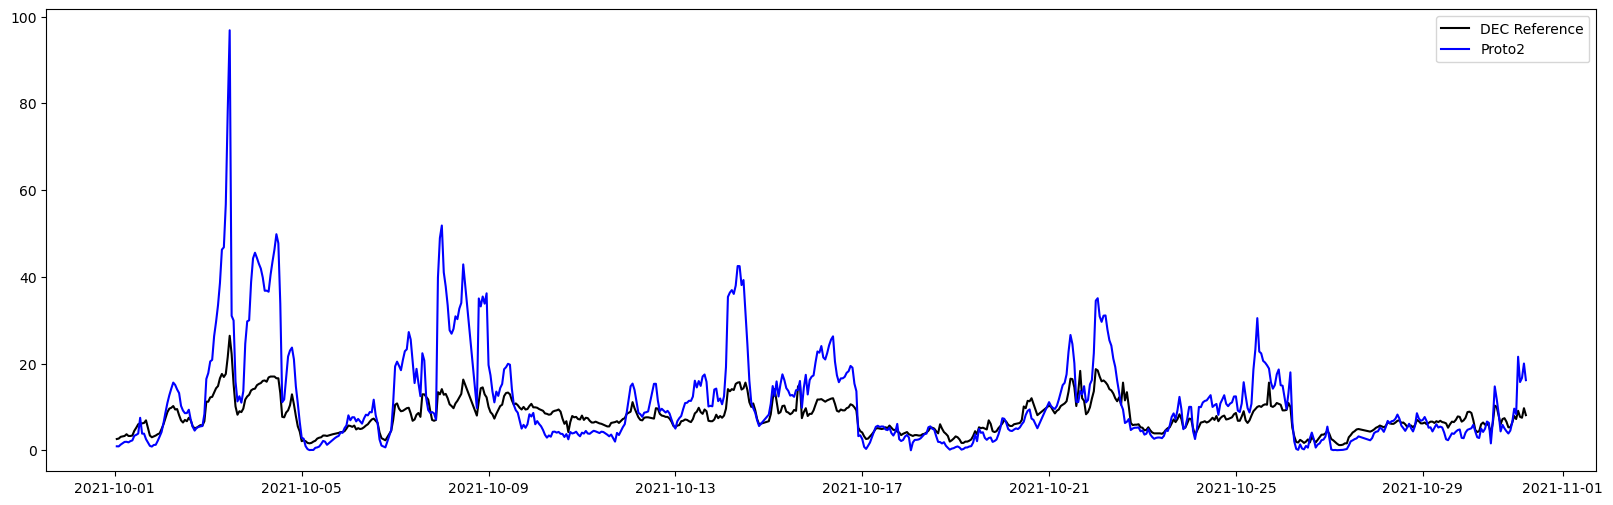

In [17]:
plt.figure(figsize=(20,6))
plt.plot(DEC_oct['PM2.5'], label='DEC Reference', color='black')
plt.plot(proto2_oct_match2DEC['pm25_std_ugm3'], label='Proto2', color='blue')
plt.legend()

### data are prepped! 

## Generate and Evaluate Regression Coefficients Using Fixed Random Sampling Method

### training and testing period dates are randomly determined but are not overlapping (meaning a date cannot be within the training and testing period)

#### .. delineate testing and training periods randomly ONCE and then write to a text file and store it for future use 

In [18]:
dates = pd.concat([DEC_oct,proto2_oct_match2DEC],axis=1) # creating dataframe of just september dates
training_dates = dates.sample(frac=0.5) # randomly select half of the data 
testing_dates = (dates.copy()).loc[~dates.copy().index.isin(training_dates.index)] # selecting data not included in previous random selection aka remaining dates 

#### .. plot to see distribution of random date selection

Text(0.5, 1.0, 'Randomly selected training and testing period for Oct (DEC Reference data plotted for pm25)')

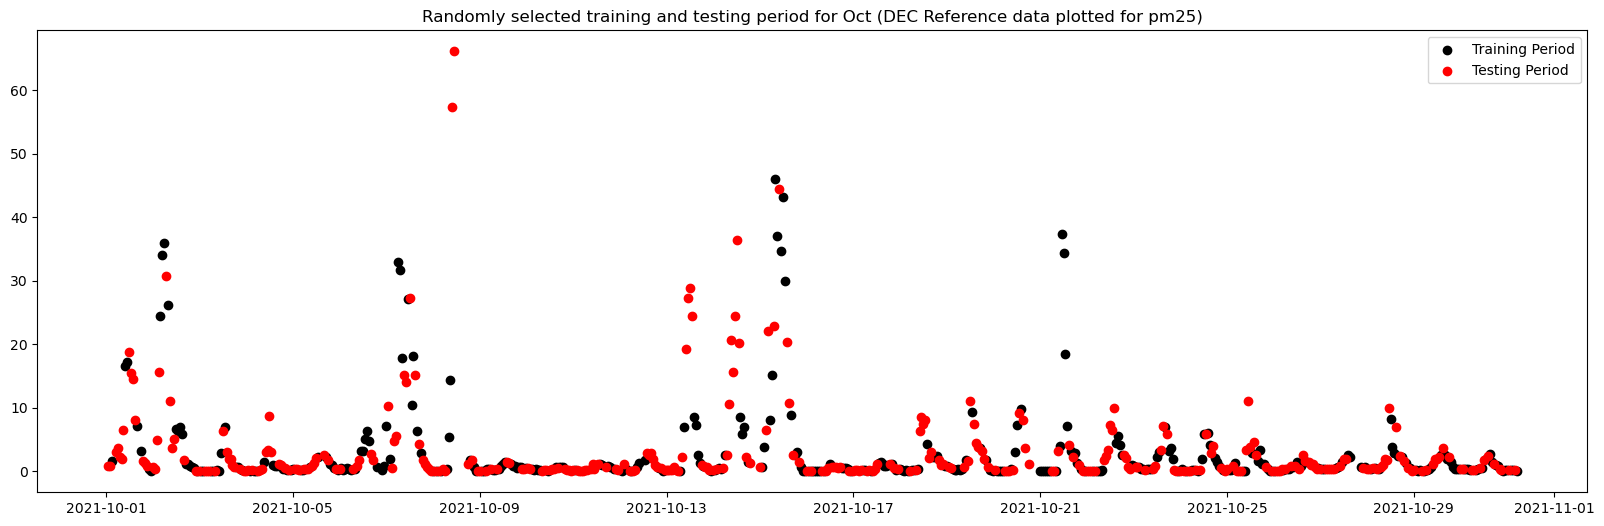

In [19]:
plt.figure(figsize=(20,6))
plt.scatter(training_dates.index,training_dates['NO'], label='Training Period', color='black')
plt.scatter(testing_dates.index,testing_dates['NO'], label='Testing Period', color='red')
plt.legend()
plt.title('Randomly selected training and testing period for Oct (DEC Reference data plotted for pm25)')

#### .. output dates to txt files

In [20]:
#os.remove("training_dates_sept.txt") # remove old text files to avoid writing over existing text 
#os.remove("testing_dates_sept.txt") # remove old text files to avoid writing over existing text 
os.remove("training_dates_oct.txt") # remove old text files to avoid writing over existing text 
os.remove("testing_dates_oct.txt") # remove old text files to avoid writing over existing text 

In [21]:
#pd.DataFrame(training_dates.index).to_csv(r'training_dates_sept.txt', header=None, index=None, sep=' ', mode='a')
#pd.DataFrame(testing_dates.index).to_csv(r'testing_dates_sept.txt', header=None, index=None, sep=' ', mode='a')
pd.DataFrame(training_dates.index).to_csv(r'training_dates_oct.txt', header=None, index=None, sep=' ', mode='a')
pd.DataFrame(testing_dates.index).to_csv(r'testing_dates_oct.txt', header=None, index=None, sep=' ', mode='a')

### apply calibration

In [22]:
epa_table={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'PM2.5'}
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}

In [23]:
coefficient_dict = {} 
pvalue_dict = {} 

Working on... CO
Plotting for  CO ...
Saving figure as... CO_October_fixedrandsampling_analysis_histo


Working on... O3
Plotting for  O3 ...
Saving figure as... O3_October_fixedrandsampling_analysis_histo


Working on... NO
Plotting for  NO ...
Saving figure as... NO_October_fixedrandsampling_analysis_histo


Working on... NO2
Plotting for  NO2 ...
Saving figure as... NO2_October_fixedrandsampling_analysis_histo


Working on... pm25
Plotting for  pm25 ...
Saving figure as... pm25_October_fixedrandsampling_analysis_histo




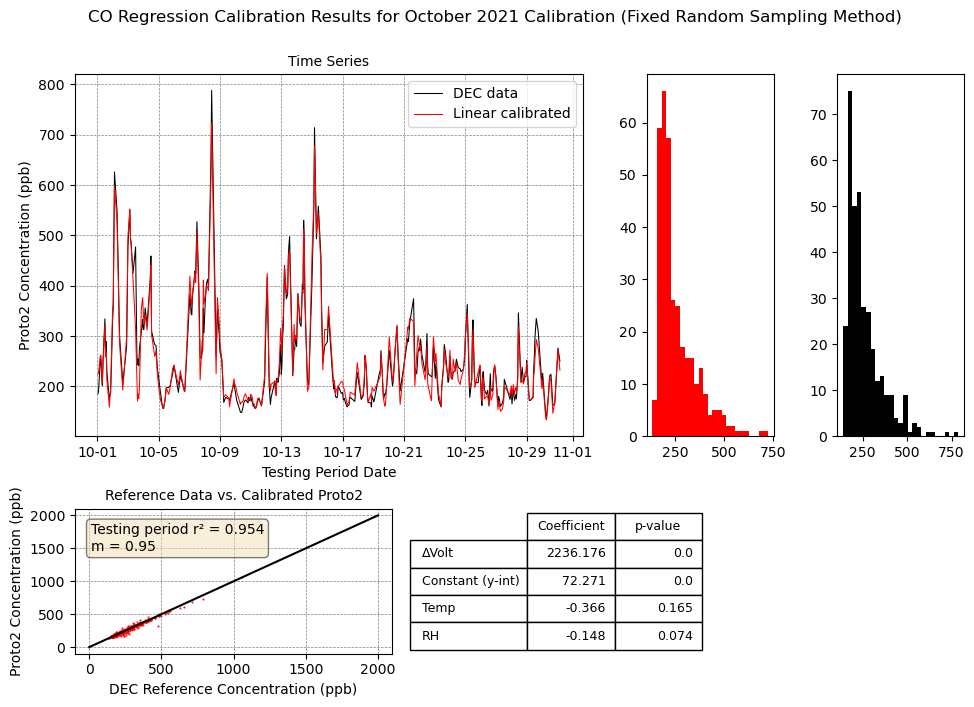

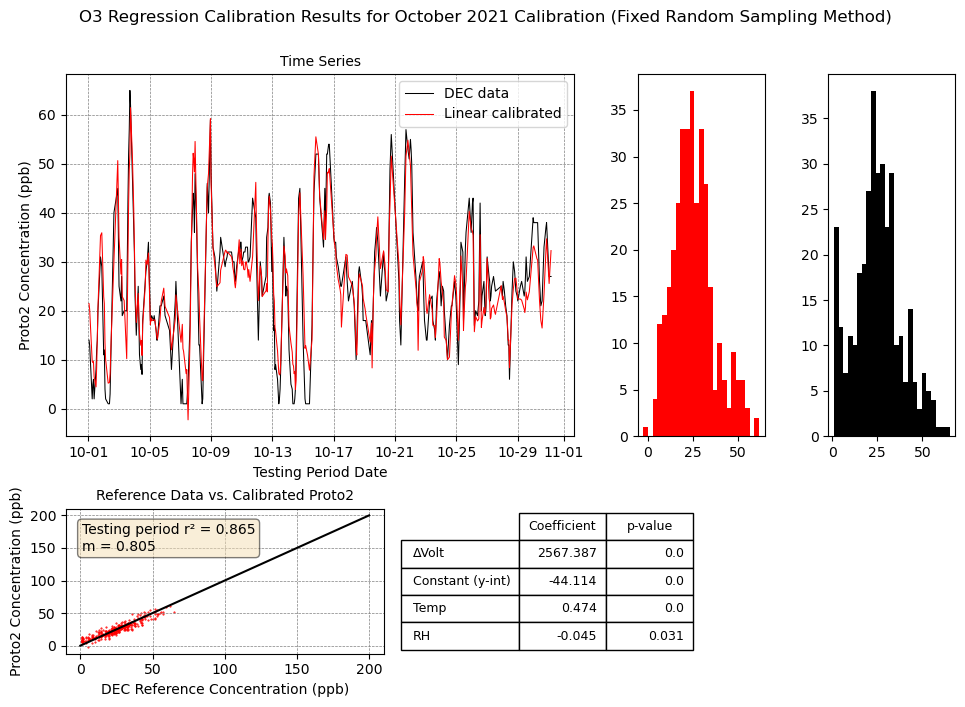

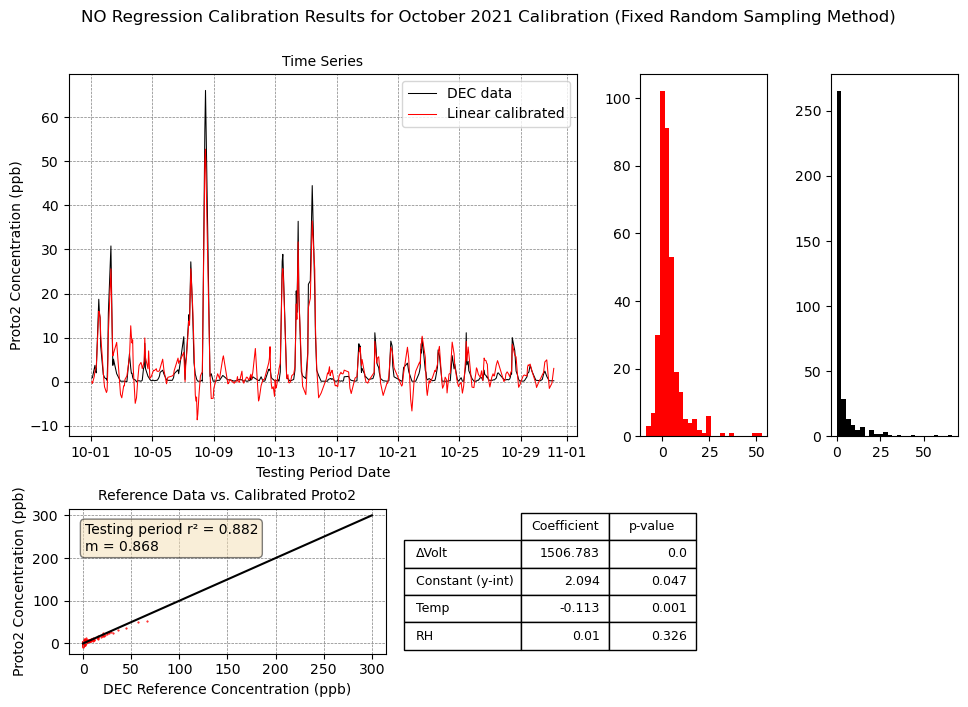

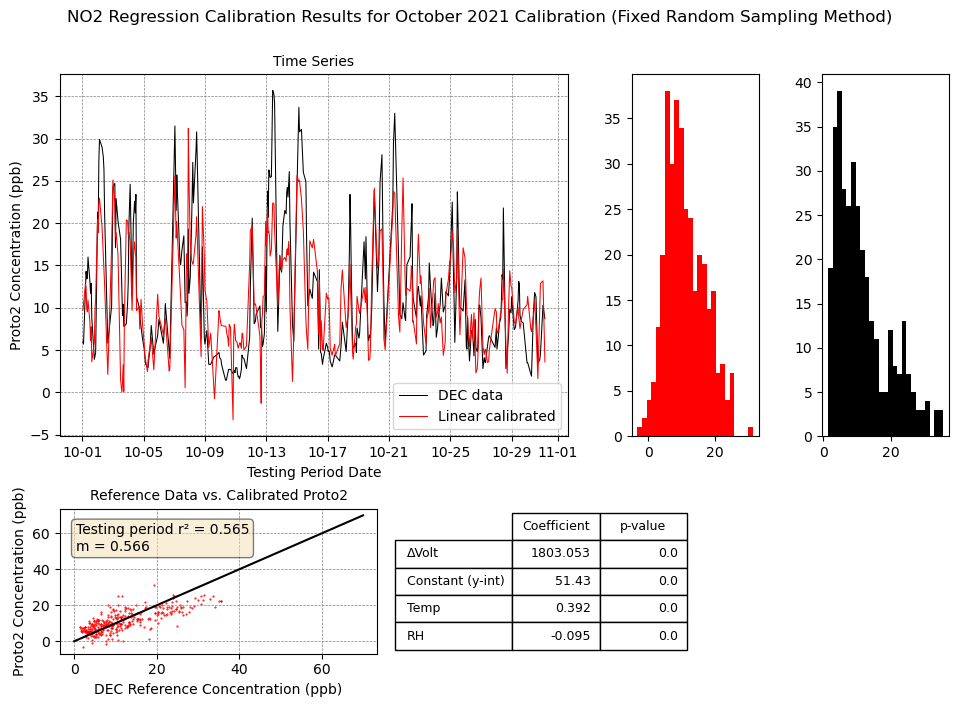

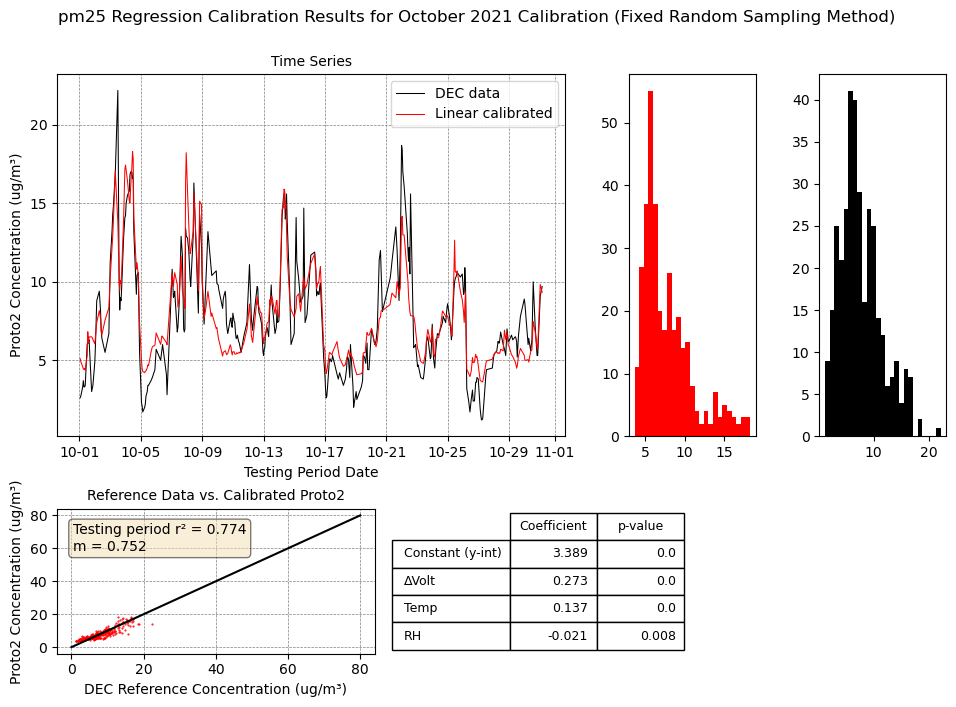

In [24]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [44201]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_oct[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_oct_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    '''
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    '''
    
    # delineate training and test periods
    combined_df_filtered_training=combined_df.loc[training_dates.index] 
    combined_df_filtered_testing=combined_df.loc[testing_dates.index]
    
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = [combined_df_filtered_training['temp_sht31_degC'], 
                     combined_df_filtered_training['rh_sht31_percent'], # RH
                     combined_df_filtered_training[gname+'_voltdiff']]
        
    training_data_input = pd.DataFrame(training_data, index=['Temp','RH','ΔVolt']).transpose()
       
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing[gname+'_voltdiff']]
                                 
                                 
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
    
    print('Working on...', gname)
    coefficients = generate_coefficients(training_data_input,training_reference_concentrations,'linear')    
    calibrated_data = calibrate(coefficients['coef_dict'], testing_data_input)
    coefficient_dict[var_id] = coefficients['coef_dict']
    pvalue_dict[var_id] = coefficients['pvalue_dict']

    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    testing_period = testing_reference_concentrations.index
       
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    shape, loc = 6, 6

    fig = plt.subplots(figsize=(12,16))
    plt.suptitle(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Fixed Random Sampling Method)', fontsize=12, x=0.35,y=0.92)

    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((shape, loc), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.75)
    time_series.legend()  
    time_series.set_title('Time Series', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((shape, loc), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'Testing period r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((shape, loc), (2, 2),colspan=2)
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.55,2)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    
    
    ''' Histograms '''
    n_bins = 25

    histogram_calibrated = plt.subplot2grid((shape, loc), (0, 3),rowspan=2)
    histogram_calibrated = plt.hist(calibrated_data, n_bins, color='red')
    
    histogram_reference = plt.subplot2grid((shape, loc), (0, 4),rowspan=2)
    histogram_reference = plt.hist(testing_reference_concentrations, n_bins, color='black')


    ''' Outputting plot ... '''
    figname = str(gname+'_'+training_period_month+'_fixedrandsampling_analysis_histo')
    print('Saving figure as...',figname)
    '''
    filepath = '/data/shared/ehojeily/september_analysis/'
    plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    '''
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')



# Calibrate winter months

In [26]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_wint = epa_df_matching_proto2.loc['2021-11-01 00:00:00+00:00':'2022-04-01 00:00:00+00:00']
proto2_wint = houravg.loc[DEC_wint.index]
proto2_wint_match2DEC = proto2_wint.loc[proto2_wint.index.isin(DEC_wint.index)]
proto2_wint_match2DEC;

Working on... CO
Plotting for  CO ...
Saving figure as... Proto2_wint_CO_October_calib_fixedrandsampling_analysis_histo




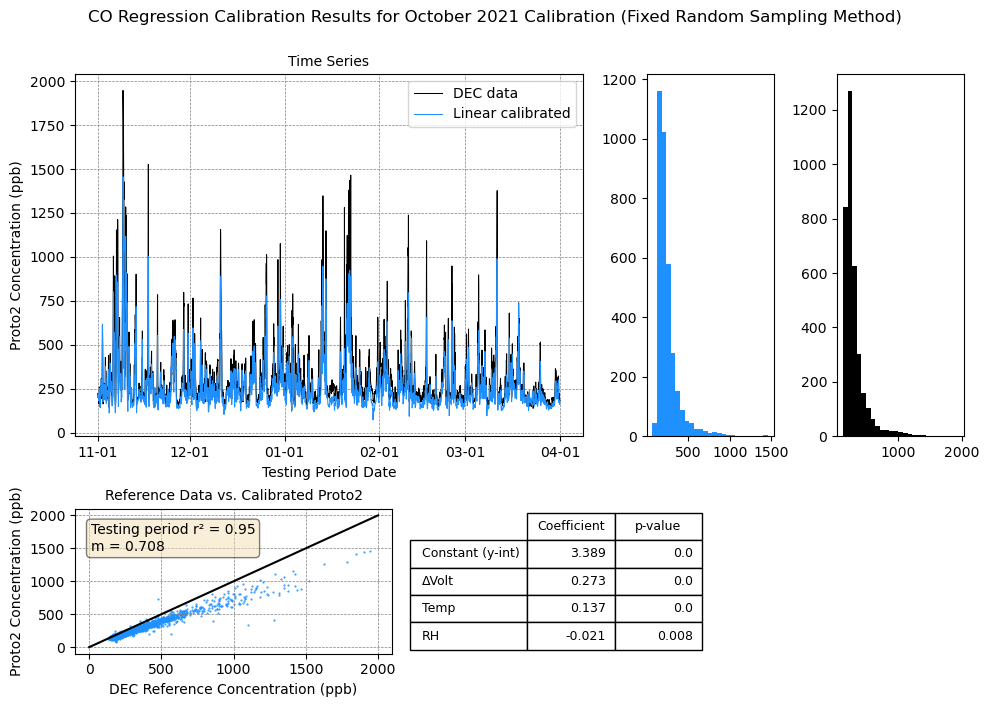

In [30]:
#for var_id in [42101, 44201, 42601, 42602, 88101]:
for var_id in [42101]:

#get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_wint[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_wint_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'

    
    # delineate training and test periods
    combined_df_filtered_testing = combined_df       
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing[gname+'_voltdiff']]
                                                            
    testing_data_input = pd.DataFrame(testing_data, index=['Temp','RH','ΔVolt']).transpose()
    
    print('Working on...', gname)
    calibrated_data = calibrate(coefficient_dict[var_id], testing_data_input)
    testing_period = testing_reference_concentrations.index
       
    ''' stats '''
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1)
    n=len(testing_reference_concentrations)
    r2_testing=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    ''' PLOT TIME :) '''
    print('Plotting for ',gname,'...')
    shape, loc = 6, 6
    fig = plt.subplots(figsize=(12,16))
    plt.suptitle(gname+' Regression Calibration Results for '+training_period_month+' 2021 Calibration (Fixed Random Sampling Method)', fontsize=12, x=0.35,y=0.92)
    linear_color = 'dodgerblue'
    
    ''' DEC vs. Calibrated time series plot (top) '''
    time_series = plt.subplot2grid((shape, loc), (0, 0), rowspan=2, colspan=3)
    time_series.set_title('time_series')
    time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    time_series.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.75)
    time_series.plot(testing_period,calibrated_data,label='Linear calibrated', color=linear_color,linewidth=0.75)
    time_series.legend()  
    time_series.set_title('Time Series', fontsize=10)
    time_series.set_xlabel('Testing Period Date')
    time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')') 
    time_series.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    
    ''' DEC vs. Calibrated trend  plot (bottom left) '''
    data_series = plt.subplot2grid((shape, loc), (2, 0), colspan=2)
    data_series.set_title('data_series')
    data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 300
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80 
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    data_series.plot(x_values, y_values, color='black', label='1:1 Line')
    # plotting data... 
    data_series.scatter(testing_reference_concentrations,calibrated_data,color=linear_color,s=0.25)
    data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
    data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
    data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)
    data_series.text(0.05, 0.90, 'Testing period r² = '+str(r2_testing.round(3))+'\nm = '+str(m[0].round(3)), 
                     transform=data_series.transAxes, fontsize=10,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    
    ''' Regression Coefficient Table (bottom right) '''
    table_data = pd.DataFrame()
    table_data = table_data.append([coefficients['coef_dict'], coefficients['pvalue_dict']],ignore_index=True).transpose().rename(columns = {0:'Coefficient', 1:'p-value'}, 
                                                                                                                                  index={'Y-intercept (constant term)':'Constant (y-int)'}).round(3)
    table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
    table = plt.subplot2grid((shape, loc), (2, 2),colspan=2)
    #hide the axes
    table.patch.set_visible(False)
    table.axis('off')
    table.axis('tight')
    regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, colLabels = table_data.columns,loc='center')
    regression_table.scale(0.55,2)
    regression_table.set_fontsize(15)
    plt.subplots_adjust(left=0, wspace=0.50, hspace=0.50)
    
    
    ''' Histograms '''
    n_bins = 25

    histogram_calibrated = plt.subplot2grid((shape, loc), (0, 3),rowspan=2)
    histogram_calibrated = plt.hist(calibrated_data, n_bins, color=linear_color)
    
    histogram_reference = plt.subplot2grid((shape, loc), (0, 4),rowspan=2)
    histogram_reference = plt.hist(testing_reference_concentrations, n_bins, color='black')


    ''' Outputting plot ... '''
    figname = str('Proto2_wint_'+gname+'_'+training_period_month+'_calib_fixedrandsampling_analysis_histo')
    print('Saving figure as...',figname)
    '''
    filepath = '/data/shared/ehojeily/september_analysis/'
    plt.savefig(filepath+figname+'.png',bbox_inches='tight',dpi=300)
    '''
    '''
    with open(filepath+'readme.txt', 'w') as f:
        f.write('Proto2 calibration analysis plots using generate_coefficients and calibrate function. \n Script used: pvalue_draft2.ipynb')
    '''
    print('\n')

